# Growth-index Fisher Forecast (GIFF) for LSST-Y1 3x2-point constraint on LCDM and beyond-LCDM parameters

In this notebook, we use [```jax-cosmo```](https://github.com/DifferentiableUniverseInitiative/jax_cosmo) to perform a Fisher forecast for the constraint on standard andd non-standard cosmological parameters from LSST Y1 data. 

# Lightning overview of cosmological parameters and Fisher forecast

## Cosmological parameters

We consider the following cosmological parameters $\mathbf{\theta}\equiv\theta_i$:

$[\Omega_m,\Omega_b,h,n_s,S_8,w_0,w_a,\gamma_0,\gamma_1]$

where $[\Omega_m,\Omega_b,h,n_s,S_8]$ are the standard, i.e. $\mathcal{L}ambda$CDM parameters,

while $[w_0,w_a]$ are the DE equation of state parameters, $w(a)=w_0+w_a(1-a)=w_0+w_a\frac{z}{1+z}$ [[1]](https://arxiv.org/abs/astro-ph/0208512),

and $[\gamma_0,\gamma_1]$ are the growth-index parameters, $\gamma(z)=\gamma_0+\gamma_1\frac{z^2}{1+z}$ [[2]](https://arxiv.org/abs/2304.07281).

## Fisher forecast

Consider the theoretical model prediction vector $\mathbf{\theta}(\mathbf{\theta})\equiv \Theta_k(\mathbf{\theta})$, the observational measurement data vector $\mathbf{\hat{\theta}}\equiv \hat{\Theta}_k$, and a Gaussian likelihood function $\mathcal{L}(\mathbf{\Theta}|\mathbf{\theta})$ of the form
$$
-2\ln\mathcal{L}(\mathbf{\Theta}|\mathbf{\theta})=N\ln(2\pi)+\ln\left[\det(\mathbf{C})\right]+\frac{1}{2}\sum_{kl}\Delta\Theta_k C_{kl}^{-1} \Delta\Theta_l,
$$
where we have assumed $N$ (correlated) measurements with the covariance $\mathbf{C}$, hence $k,l\in[1,2,...N]$, and the shorthand notation $\Delta\Theta_k\equiv\Theta_k(\mathbf{\theta})-\hat{\Theta}_k$.

The Fisher information matrix is defined as the curvature, or Hessian, of the likelihood function w.r.t. the model parameters

$$
F_{ij}=-\left\langle\frac{\partial^2\ln \mathcal{L}}{\partial\theta_i\partial\theta_j}\right\rangle.
$$
We further decompose the Fisher matrix using the chain rule as follows
$$
F_{ij}=-\left\langle\frac{\partial\Theta_k(\mathbf{\theta})}{\partial\theta_i}\cdot\frac{\partial^2\ln\mathcal{L}}{\partial\Delta\Theta_k\partial\Delta\Theta_l}\cdot\frac{\partial\Theta_l(\mathbf{\theta})}{\partial\theta_j}\right\rangle,
$$
where repeated indices are summed over according to Einstein summation convention.

## ```jax``` and ```jax-cosmo``` libraries

In [1]:
## jax library for autodiff
import jax
## enable/disable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
from jax.scipy.linalg import eigh, inv
from jax.scipy.stats import norm

## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc

## CCL - DESC cosmology library, serves a cross-check of the Fisher matrix stability in jax-cosmo
#import pyccl as ccl

## Load utility modules and define utility functions

In [47]:
## os library for computer path
import os.path

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

## personal preference for matplotlib fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Computer Modern",
    "font.size": 22})

#Methods to easily save and load fisher matrices to storage
from numpy import savetxt, loadtxt

def saveFisher(fid_vals, fisher, fname='LCDM_S8_LSSTY1_fisher.csv', delimiter=',', **kwargs):
   mat = np.append(fisher, np.reshape(fid_vals, (1, fisher.shape[0])), axis=0)
   savetxt(fname, mat, delimiter=delimiter, **kwargs)

def loadFisher(fname : str, delimiter=',', **kwargs):
   mat = loadtxt(fname, delimiter=delimiter, **kwargs)
   fisher = mat[:mat.shape[1], :mat.shape[1]]
   fid_vals = mat[mat.shape[1], :]
   return fid_vals, fisher

def plot_contours(cov, pos, inds, cls=np.array([0.6827, 0.9545]), ax=None, **kwargs):
    """
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    Parameters:
    -----------
    fisher : (M, M) array_like
        Input Fisher matrix.
    pos : (M,) array_like
        Fiducial parameter values.
    inds : (2,) array_like
        Parameter indices.
    cl1, cl2 : float
        Confidence levels of ellipse contours.
    """
    
    def eigsorted(cov):
        vals, vecs = eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    def sigma_marg(cov, i):
        return np.sqrt(cov[i, i])
        
    cov = cov[inds][:, inds]
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    cls = .5*(1+cls)
    nstds = norm.ppf(cls)
    #nstd1 = norm.ppf(0.5 * (1 + cl1))
    #nstd2 = norm.ppf(0.5 * (1 + cl2))

    ellip1 = Ellipse(xy=pos[inds], width=2.0 * nstds[0] * np.sqrt(vals[0]),
                     height=2.0 * nstds[0] * np.sqrt(vals[1]), angle=theta, alpha=0.8,**kwargs)
    ellip2 = Ellipse(xy=pos[inds], width=2.0 * nstds[1] * np.sqrt(vals[0]),
                     height=2.0 * nstds[1] * np.sqrt(vals[1]), angle=theta, alpha=0.2,**kwargs)
    ellips=[ellip1,ellip2]

    if ax is None:
        ax = plt.gca()

    for ellip in ellips:
       ax.add_artist(ellip)

    nstdmax = max(nstds)
    sx = nstdmax * sigma_marg(cov, 0)
    sy = nstdmax * sigma_marg(cov, 1)
    ax.set_xlim(pos[inds[0]] - 1.5*sx, pos[inds[0]] + 1.5*sx)
    ax.set_ylim(pos[inds[1]] - 1.5*sy, pos[inds[1]] + 1.5*sy)

    return ellips

def plot_Gaussian(cov, pos, ind, cl=0.9545, ax=None, **kwargs):
  mu = pos[ind]
  sigma = np.sqrt(cov[ind,ind])
  if ax is None:
    ax = plt.gca()
  num = 100
  if 'num' in kwargs.keys():
     num = kwargs['num']
  nstd = norm.ppf(.5*(1+cl))
  x = np.linspace(mu-1.5*nstd*sigma, mu+1.5*nstd*sigma, num=num, endpoint=True)
  N = np.exp(-.5*((x-mu)/sigma)**2)
  ax.plot(x, N, **kwargs)
  ax.set_xlim((x[0], x[-1]))

cosmo_param_nr=8
## The correct way to have a varying number of cosmological parameters and number of z bins)
## would have been inplementing variables controls that number and including some ```if``` statements
## but for the sake of simplicity (and performance) in this example, we're not doing so
## and instead specifying that number as a global variable directly above
def get_params_vec(cosmo,  b_l, ia, dz_l, m_s, dz_s):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    b1, b2, b3, b4, b5 = b_l
    A, eta = ia
    dz1_l, dz2_l, dz3_l, dz4_l, dz5_l = dz_l
    m1, m2, m3, m4, m5 = m_s
    dz1_s, dz2_s, dz3_s, dz4_s, dz5_s = dz_s
    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, gamma, w0, wa] 
        #cosmo.Omega_k,
        cosmo.Omega_m, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.sigma8,
        cosmo.w0, cosmo.wa,
        cosmo.gamma0,
        #cosmo.gamma0, cosmo.gamma1,
        # Lens - Galaxy bias
        b1, b2, b3, b4, b5,
        # Source - Galaxy IA
        A, eta,
        # Lens - Photometric redshift calibration systematics
        dz1_l, dz2_l, dz3_l, dz4_l, dz5_l,
        # Source - Shear measurement calibration systematics
        m1, m2, m3, m4, m5,
        # Source - Photometric redshift calibration systematics
        dz1_s, dz2_s, dz3_s, dz4_s, dz5_s
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    b1,b2,b3,b4,b5 = params[cosmo_param_nr:cosmo_param_nr+5]
    A = params[cosmo_param_nr+5]
    eta = params[cosmo_param_nr+6]
    dz1_l,dz2_l,dz3_l,dz4_l,dz5_l = params[cosmo_param_nr+7:cosmo_param_nr+12]
    m1,m2,m3,m4,m5 = params[cosmo_param_nr+12:cosmo_param_nr+17]
    dz1_s,dz2_s,dz3_s,dz4_s,dz5_s = params[cosmo_param_nr+17:cosmo_param_nr+22]
    return cosmo, [b1,b2,b3,b4,b5],  [A, eta], [dz1_l,dz2_l,dz3_l,dz4_l,dz5_l], [m1,m2,m3,m4,m5], [dz1_s,dz2_s,dz3_s,dz4_s,dz5_s]

## Generate redshift distributions

### Generate source and lens n(z)

We follow the updated analysis/modeling choices and parameters on LSST-DESC srd [repo](https://github.com/LSSTDESC/forecasting/blob/main/desc_srd/SRD_data_vectors/SRD%20parameters/lsst_desc_parameters.yaml).

Specifically, we assume the unbinned galaxies follow a Smail redshift distribution
$$n(z)\propto z^2\mathrm{exp}[-(z/z_0)^\alpha],$$
where $(z_0,\alpha)$ vary between lens and source samples. We further divide lens and source samples each into 5 tomographic bins.

In [3]:
n_source_eff = 10.
nz_s = jc.redshift.smail_nz(2, .78, 0.13, gals_per_arcmin2 = n_source_eff)

n_lens_eff = 18.
nz_l = jc.redshift.smail_nz(2, .94, .26, gals_per_arcmin2=n_lens_eff)

### Retrieve $n(z)$ and $z$ files

In [4]:
data_https='https://raw.githubusercontent.com/MinhMPA/forecasting/main/updated_forecasts/datafiles/z_bins'

#### Lens sample

In [5]:
LSSTY1_lens_zunbinned_file='z_values_unbinned.txt'
if not os.path.isfile(LSSTY1_lens_zunbinned_file):
    !wget -O "$LSSTY1_lens_zunbinned_file" "$data_https"/"$LSSTY1_lens_zunbinned_file"

In [6]:
LSSTY1_lens_zbin_file='z_bin_centers_y1_lens.txt'
if not os.path.isfile(LSSTY1_lens_zbin_file):
    !wget -O "$LSSTY1_lens_zbin_file" "$data_https"/"$LSSTY1_lens_zbin_file"

In [7]:
LSSTY1_lens_nz_file='nz_y1_lens.txt'
if not os.path.isfile(LSSTY1_lens_nz_file):
    !wget -O "$LSSTY1_lens_nz_file" "$data_https"/"$LSSTY1_lens_nz_file"

#### Source sample

In [8]:
LSSTY1_source_zbin_file='z_bin_centers_y1_source.txt'
if not os.path.isfile(LSSTY1_source_zbin_file):
    !wget -O "$LSSTY1_source_zbin_file" "$data_https"/"$LSSTY1_source_zbin_file"

In [9]:
LSSTY1_source_nz_file='nz_y1_source.txt'
if not os.path.isfile(LSSTY1_source_nz_file):
    !wget -O "$LSSTY1_source_nz_file" "$data_https"/"$LSSTY1_source_nz_file"

### Estimate $n(z)$ in bins from $n(z)$ and $z$ data

#### Lens sample

In [10]:
## Specify the numbers of bins here
lens_nbins=5

zs_l = loadtxt(LSSTY1_lens_zunbinned_file)
zbin_center_l = loadtxt(LSSTY1_lens_zbin_file)
zbin_edge_l = [0.2,]
for i in range(lens_nbins):
    zbin_edge_l.append(2.*(zbin_center_l[i]-zbin_edge_l[-1])+zbin_edge_l[-1])
zbin_edge_l=np.asarray(zbin_edge_l)
zbin_width_l=zbin_edge_l[1:]-zbin_edge_l[:-1]
binned_nz_l = [loadtxt(LSSTY1_lens_nz_file, usecols=i) for i in range(lens_nbins)]

## Currently adopting the same values for both MagLim and redMaGiC samples
KDE_bw_l=0.03*(1.+zbin_center_l) # bandwidth of the KDE
KDE_zmax_l=1.2 # the cutoff redshift for lens samples in the KDE

nzs_l = [jc.redshift.kde_nz(zs_l.astype('float32'),
                        binned_nz_l[i].astype('float32'), 
                        bw=KDE_bw_l[i],
                        bwz_scale=1.0,
                        gals_per_arcmin2=nz_l(zbin_center_l[i]),
                        zmax=KDE_zmax_l)
       for i in range(lens_nbins)]

#### Source sample

In [11]:
## Specify the numbers of bins here
source_nbins=5

zs_s = zs_l
zbin_center_s = loadtxt(LSSTY1_source_zbin_file)
zbin_edge_s = [0.2,]
for i in range(source_nbins):
    print
    zbin_edge_s.append(2.*(zbin_center_s[i]-zbin_edge_s[i])+zbin_edge_s[i])
zbin_edge_s=np.asarray(zbin_edge_s)
zbin_width_s=zbin_edge_s[1:]-zbin_edge_s[:-1]
binned_nz_s = [loadtxt(LSSTY1_source_nz_file, usecols=i) for i in range(source_nbins)]

## Currently adopting the same values for both MagLim and redMaGiC samples
KDE_bw_s=0.05*(1.+zbin_center_s) # bandwidth of the KDE
KDE_zmax_s=zs_s.max() # the cutoff redshift for source samples in the KDE

nzs_s = [jc.redshift.kde_nz(zs_s.astype('float32'),
                        binned_nz_s[i].astype('float32'), 
                        bw=KDE_bw_s[i],
                        bwz_scale=1.0,
                        gals_per_arcmin2=nz_s(zbin_center_s[i]),
                        zmax=KDE_zmax_s)
       for i in range(source_nbins)]

## Visualize redshift distributions

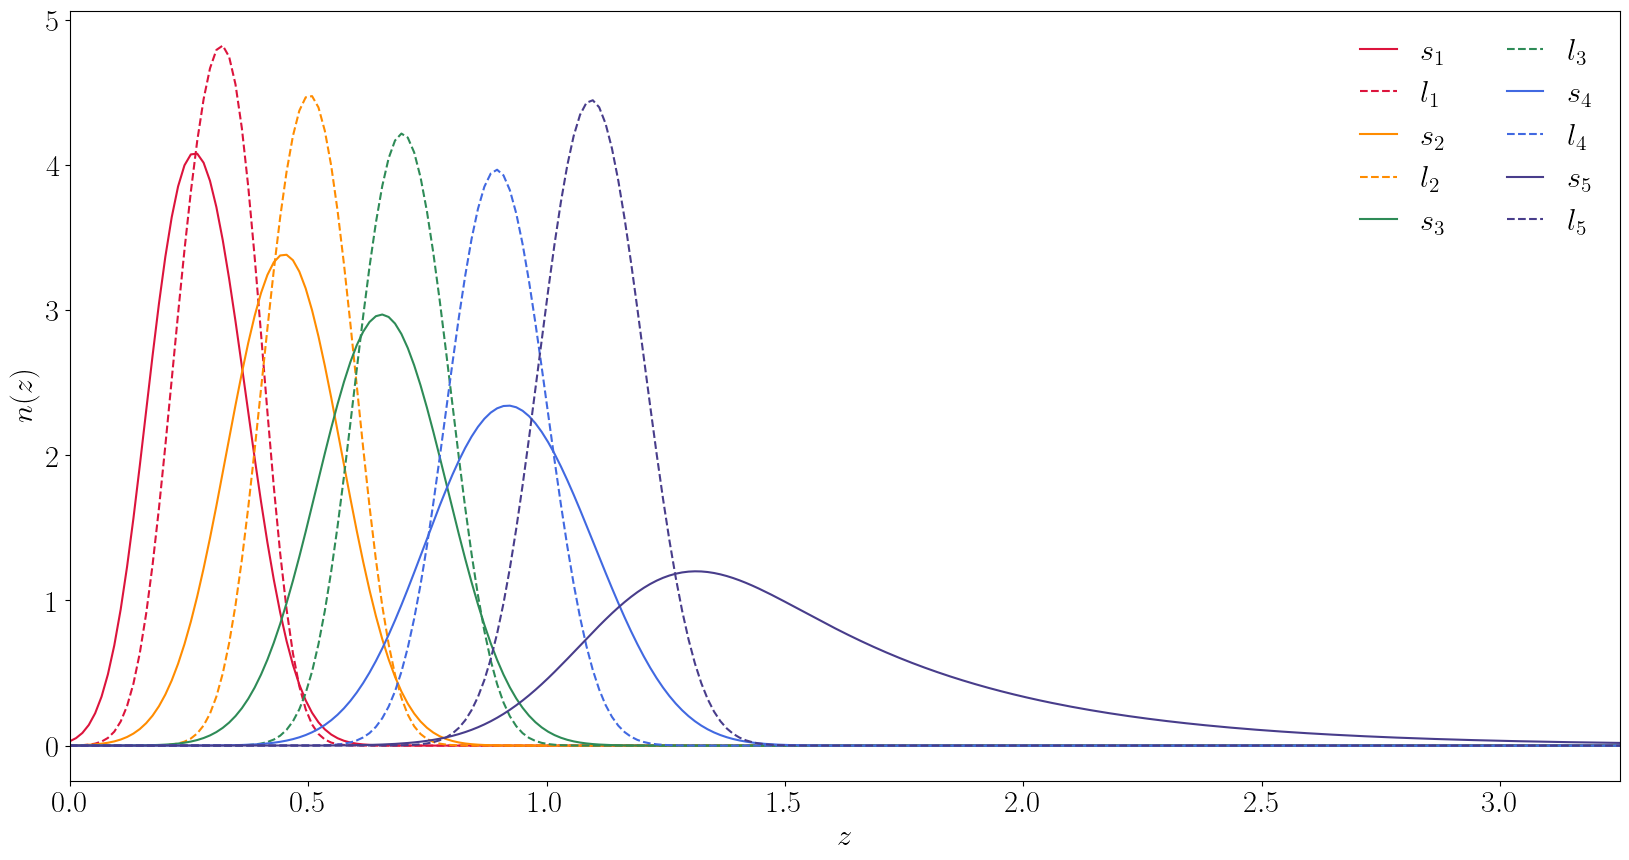

In [12]:
z = np.linspace(0.,4., 300)

colors=['crimson','darkorange','seagreen','royalblue','darkslateblue']
fig, ax = plt.subplots(1,1,figsize=(20,10))
for i in range(min(len(nzs_s), len(nzs_l))):
    ax.plot(z, nzs_s[i](z), ls='-',c=colors[i],label=r'$s_{}$'.format(i+1))
    ax.plot(z, nzs_l[i](z), ls='--',c=colors[i],label=r'$l_{}$'.format(i+1))
    ax.set_xlim(0.,3.25)
    ax.legend(frameon=False,ncols=2,loc='upper right',handlelength=1.2)
    ax.set_ylabel(r'$n(z)$')
    ax.set_xlabel(r'$z$')

## Define the forecast setup

### Fiducial cosmology

See the ``Plik best fit'' column in Table 1 of [Planck 2018 paper](https://arxiv.org/abs/1807.06209)

In [13]:
PL18_h=0.6732
PL18_omegac=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_sigma8=0.812
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma0=0.55
GR_gamma1=0.

#### Create a jax-cosmo Cosmology object for the fiducial cosmology

In [14]:
fid_cosmo = jc.Cosmology(Omega_m=PL18_omegac+PL18_omegab,
                         Omega_c=PL18_omegac,
                         Omega_b=PL18_omegab,
                         h=PL18_h,
                         n_s=PL18_ns,
                         sigma8=PL18_sigma8,
                         S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**0.5,
                         #Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa, gamma0=None, gamma1=None)
                         Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa, gamma0=GR_gamma0, gamma1=GR_gamma1)

### Fiducial survey specs

#### Sky fraction

Sky coverage in square degrees and fraction

In [15]:
full_sky=41252.9612  # full sky in square degrees
lsst_sky=18000  # LSST sky coverage; in square degrees
lsst_fsky=lsst_sky/full_sky  # fraction of the sky covered by LSST

### Source systematics

There are three sources of systematics for source galaxies:

- Shear measurement calibration error;
- Photometric redshift (photo-z) calibration error;
- Intrinsic Alignment (IA) of source galaxies with the underlying tidal field, hence themselves.


#### Shear measurement calibration systematics

We have five parameters $m^i$ for five redshift bins of the source samples.
A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [16]:
m_s = [0.,0.,0.,0.,0.]

#### Photo-z calibration systematics

Similarly, we have four parameters $\Delta z_s^i$ for four redshift bins of the source samples.A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [17]:
dz_s = [0.0,0.0,0.0,0.0,0.0]

#### Intrinsic Alignment (of source galaxies)

We use the NLA model for IA:
$$A(z)=A_0\left[\frac{1+z}{1+z_0}\right]^\eta$$
where the pivot redshift $z_0$ is fixed at 0.62.
For fiducial values, we use the means of posteriors in the third row of Table 3 of [the DES Y3 cosmic shear paper](https://arxiv.org/pdf/2105.13544.pdf)

In [18]:
A0, eta = [.5, 0.]
z0 = .62

### Lens systematics

There are two sources of systematics for lens galaxies:

- Photometric redshift calibration error;
- Galaxies are biased tracer of the underlying matter distribution.

#### Photometric (Photo-z) calibration systematics

Here, we have five parameters $\Delta z_l^i$ for five redshift bins of the lens samples. A priori, there is no particular preference for positive or negative shifts so we adopt zeros as fiducial values.

In [19]:
dz_l = [0.,0.,0.,0.,0.]

#### Galaxy bias systematics

Here we adopt the fiducial values for the linear galaxy bias parameters $b^i_l$ of lens galaxies from the values assumed in LSST Science Requirement Document, section D1, page 48 ([arXiv:1809.01669](https://arxiv.org/abs/1809.01669)).

In [20]:
b_l = [1.562362, 1.732963, 1.913252, 2.100644, 2.293210]

### Pack a parameter vector including both cosmological and systematic parameters

In [21]:
fid_params = get_params_vec(fid_cosmo,
                            b_l,
                            [A0, eta],
                            dz_l,
                            m_s,
                            dz_s)

## Compute the mean of the 3x2-point data vector using the ```jax-cosmo``` library

### Standard input parameter(s) for the function

In [22]:
## Specify a range of multipole ell values
ell_max=4000.
lmax_s=[3000,3000,3000,3000,3000]
lmax_l=[ 370,  585,  775,  945,
       1095]
#lmax_s=[2e4,2e4,2e4,2e4,2e4]
#lmax_l=[2e4,2e4,2e4,2e4,2e4]
ell = np.logspace(1,np.log10(ell_max),num=50)

### Cosmic Shear $C_{\gamma\gamma}(\ell)$

In [23]:
@jax.jit
def compute_cosmic_shear_mean(params,nzs_source=nzs_s,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         #S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         #w0=PL18_w0, wa=PL18_wa,
                         #gamma0=None, gamma1=None)
                         sigma8=cosmo_params[4], S8= cosmo_params[4]*(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7], gamma1=GR_gamma1)
                         #gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys,
                                    lmax=lmax_s,
                                    ia_bias=a_ia,
                                    multiplicative_bias=m)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

### Galaxy clustering $C_{gg}(\ell)$

In [24]:
@jax.jit
def compute_ggclustering_mean(params,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         #S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         #w0=PL18_w0, wa=PL18_wa,
                         #gamma0=None, gamma1=None)
                         sigma8=cosmo_params[4], S8= cosmo_params[4]*(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7],gamma1=GR_gamma1)
                         #gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l]
    
    ## Define the lensing and number counts probe
    probes = [jc.probes.NumberCounts(nzs_l_sys, b, lmax=lmax_l)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

### Galaxy-galaxy lensing $C_{g\gamma}(\ell)$

In [25]:
@jax.jit
def compute_gglensing_mean(params,nzs_source=nzs_s,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         #S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         #w0=PL18_w0, wa=PL18_wa,
                         #gamma0=None, gamma1=None)
                         sigma8=cosmo_params[4], S8= cosmo_params[4]*(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7],gamma1=GR_gamma1)
                         #gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)

    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    
    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys,
                                    lmax=lmax_s,
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b, lmax=lmax_l)]

    cl = jc.angular_cl.angular_cl_gglensing(cosmo, ell, probes)

    return cl

### Putting probes together to form the 3x2-point $C_{AB}(\ell)$ observable vector

In [26]:
@jax.jit
def compute_3x2pt_mean(params,nzs_source=nzs_s,nzs_lens=nzs_l,ell=ell, zpivot_ia = z0):
    """
    Returns the mean signal of a 3x2-point data vector
    """
    ## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         #S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         #w0=PL18_w0, wa=PL18_wa,
                         #gamma0=None, gamma1=None)
                         sigma8=cosmo_params[4], S8= cosmo_params[4]*(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7],gamma1=GR_gamma1)
                         #gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l] 

    ## Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys,
                                    lmax=lmax_s,
                                    ia_bias=a_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l_sys, b, lmax=lmax_l)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl.flatten()

### Visualize the angular power spectra $C_{AB}(\ell)$ for probe A and B

A quick visual inspection of the $C(\ell)$ given fiducial cosmological and astrophysics/systematics parameters

In [27]:
means_3x2pt = compute_3x2pt_mean(fid_params,nzs_s,nzs_l)
mean_cosmic_shear = compute_cosmic_shear_mean(fid_params,nzs_s)
mean_ggclustering = compute_ggclustering_mean(fid_params,nzs_l)
mean_gglensing = compute_gglensing_mean(fid_params,nzs_s,nzs_l)
means = [mean_cosmic_shear,mean_gglensing,mean_ggclustering]

#%timeit compute_3x2pt_mean(fid_params,nzs_s).block_until_ready()

### Plot the angular spectra from individual probes

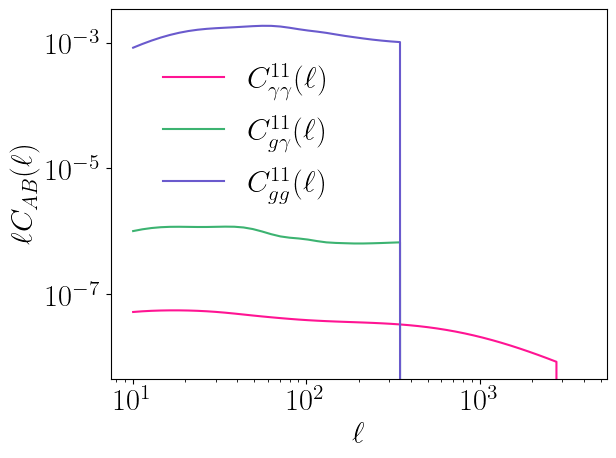

In [28]:
fig, ax = plt.subplots()
ax.loglog(ell,ell*mean_cosmic_shear[0,:],c='deeppink',label=r'$C_{\gamma\gamma}^{11}(\ell)$')
ax.loglog(ell,ell*mean_gglensing[0,:],c='mediumseagreen',label=r'$C_{g\gamma}^{11}(\ell)$')
ax.loglog(ell,ell*mean_ggclustering[0,:],c='slateblue',label=r'$C_{gg}^{11}(\ell)$')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell C_{AB}(\ell)$')
ax.legend(frameon=False,bbox_to_anchor=[0.05,0.4],loc='lower left')

### Plot the angular cosmic shear spectra from individual redshift bins

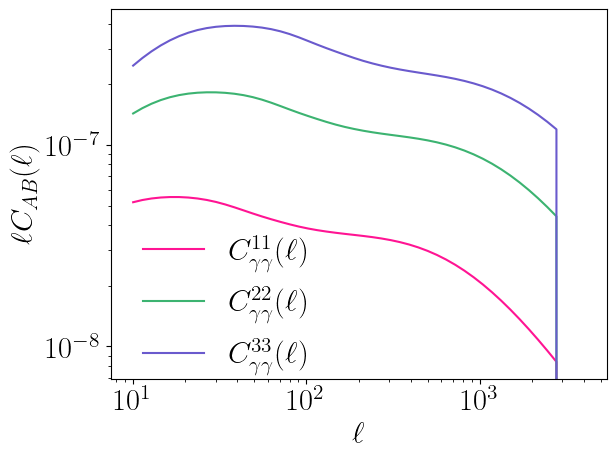

In [29]:
fig, ax = plt.subplots()
ax.loglog(ell,ell*mean_cosmic_shear[0,:],c='deeppink',label=r'$C_{\gamma\gamma}^{11}(\ell)$')
ax.loglog(ell,ell*mean_cosmic_shear[5,:],c='mediumseagreen',label=r'$C_{\gamma\gamma}^{22}(\ell)$')
ax.loglog(ell,ell*mean_cosmic_shear[9,:],c='slateblue',label=r'$C_{\gamma\gamma}^{33}(\ell)$')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell C_{AB}(\ell)$')
ax.legend(frameon=False,bbox_to_anchor=[0.01,-0.065],loc='lower left')
#ax.set_ylim(1e-20,1e-3)
#ax.axhline(y=1E-9,ls='--',c='k')
#ax.axvline(x=1E2,ls='--',c='k')

## Compute the covariance at the fiducial cosmology using ```jax-cosmo```

### Define the function to compute covariance matrix for individual probes and the 3x2-pt combination

In [30]:
@jax.jit
def compute_gaussian_covariance(params,nzs_source,nzs_lens=nzs_l,ell=ell,f_sky=0.25, zpivot_ia=z0):
    """
    Rerturns the Gaussian covariance for a 3x2pt data vector
    """
## First unpack parameter vector
    cosmo_params, b_l, (A, eta), dz_l, m, dz_s = unpack_params_vec(params)
    #cosmo_params, (A, eta), m, dz_s = unpack_params_vec(params)

    ## Specify cosmology
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         #S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         #w0=PL18_w0, wa=PL18_wa,
                         #gamma0=None, gamma1=None)
                         sigma8=cosmo_params[4], S8=cosmo_params[4]*(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7],gamma1=GR_gamma1)
                         #gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    
    ## Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_source, dz_s)]
    ## Define IA model
    a_ia = jc.bias.des_y1_ia_bias(A, eta, zpivot_ia)
    
    ## Build lens nz with redshift systematic bias
    nzs_l_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_lens, dz_l)]
    ## Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in b_l]

    ## Define the lensing and number counts probe
    # probes = [jc.probes.WeakLensing(nzs_s_sys, 
    #                                 ia_bias=a_ia,
    #                                 multiplicative_bias=m),
    #          jc.probes.NumberCounts(nzs_l_sys, b)]
    shear_probe = [jc.probes.WeakLensing(nzs_s_sys,
                                         lmax=lmax_s,
                                    ia_bias=a_ia,
                                    multiplicative_bias=m)]
    count_probe = [jc.probes.NumberCounts(nzs_l_sys, b, lmax=lmax_l)]
    probes = [shear_probe[0],count_probe[0]]
    
    shear_cl_signal = jc.angular_cl.angular_cl(cosmo, ell, shear_probe)
    shear_cl_noise = jc.angular_cl.noise_cl(ell, shear_probe)
    shear_cov = jc.angular_cl.gaussian_cl_covariance(ell, shear_probe, shear_cl_signal, shear_cl_noise, f_sky=f_sky, sparse=False)
    
    cl_signal = jc.angular_cl.angular_cl(cosmo, ell, probes)
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    gglensing_cov = jc.angular_cl.gaussian_cl_gglensing_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    
    ggclustering_cl_signal = jc.angular_cl.angular_cl(cosmo, ell, count_probe)
    ggclustering_cl_noise = jc.angular_cl.noise_cl(ell, count_probe)
    ggclustering_cov = jc.angular_cl.gaussian_cl_covariance(ell, count_probe, ggclustering_cl_signal, ggclustering_cl_noise, f_sky=f_sky, sparse=False)
    
    return cov, shear_cov, gglensing_cov, ggclustering_cov

### Compute the covariance (and the inverse)

Recall that the inverse of the covariance matrix is the *precision matrix*.

In [31]:
cov_mat, shear_cov_mat, gglensing_cov_mat, ggclustering_cov_mat = compute_gaussian_covariance(fid_params,nzs_s, f_sky = lsst_fsky)
prc_mat = np.linalg.inv(cov_mat)
print(cov_mat.shape)
print(shear_cov_mat.shape)
print(gglensing_cov_mat.shape)
print(ggclustering_cov_mat.shape)

(2750, 2750)
(750, 750)
(1250, 1250)
(750, 750)


### Visualize the covariance matrices

### shear-shear, galaxy-galaxy lensing, and galaxy-galaxy covariance matrices

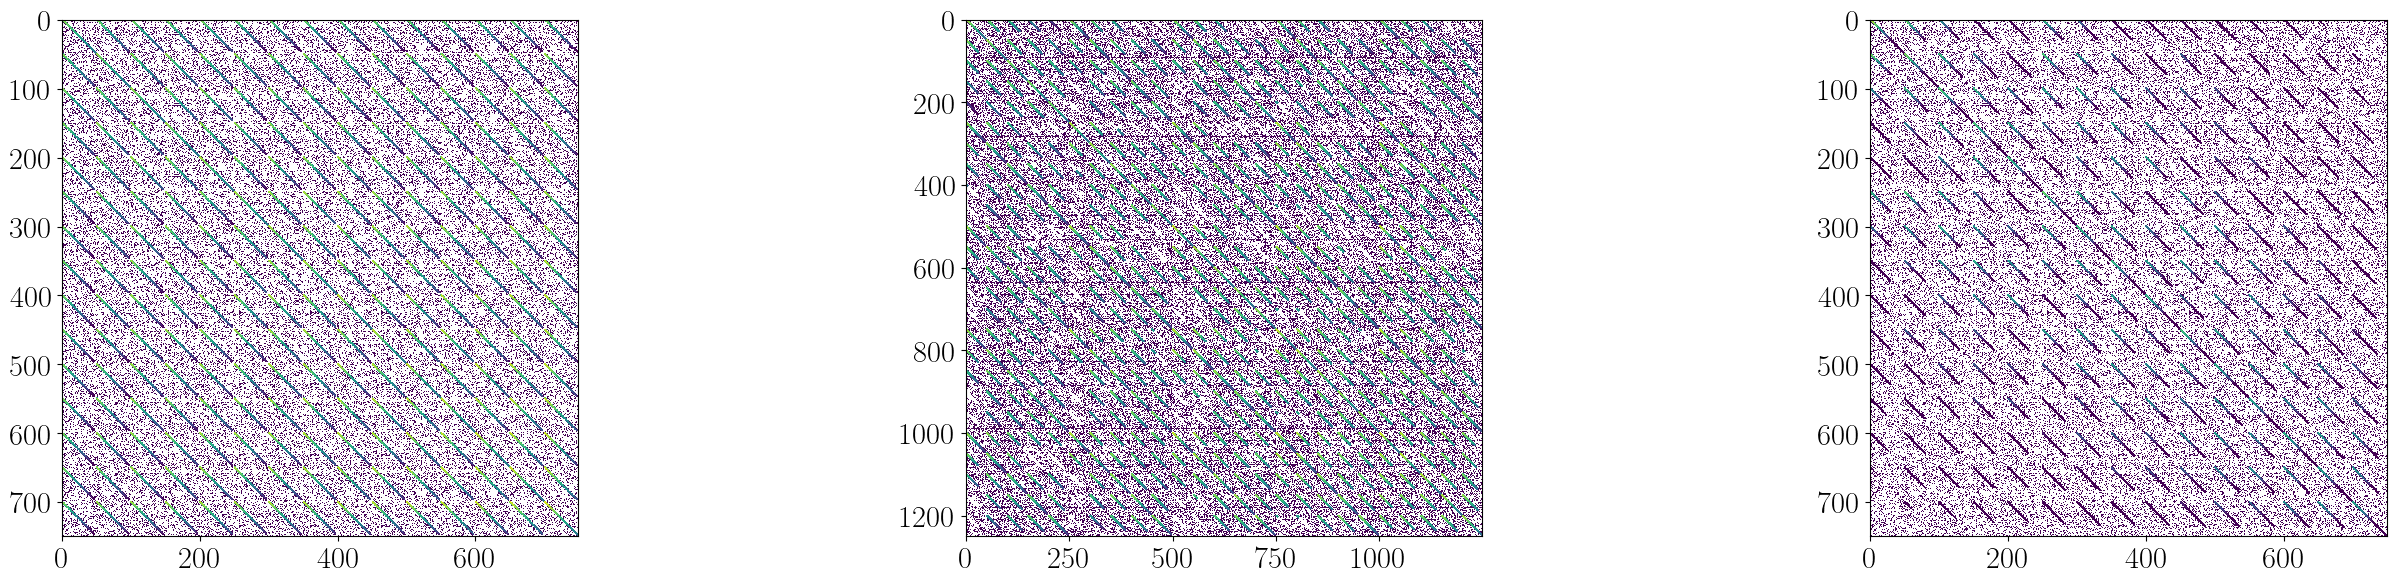

In [32]:
fig,ax=plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(shear_cov_mat,norm='log')
ax[1].imshow(gglensing_cov_mat,norm='log')
ax[2].imshow(ggclustering_cov_mat,norm='log')
plt.subplots_adjust(wspace=0.75)

### 3x2-pt covariance matrix

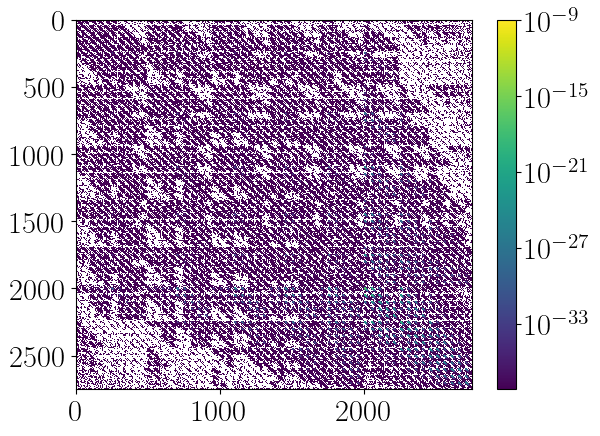

In [33]:
plt.imshow(cov_mat,norm='log',aspect='auto')
plt.colorbar();

## Compute the Jacobian using ```jax-cosmo```

So we have got the precision matrix $\mathbf{C}^{-1}$.

To form the Fisher matrix, we still need the Jacobian $\frac{\partial\Theta_k(\mathbf{\theta})}{\partial\theta_i}$.

Computing the Jacobian using ```jax-cosmo``` is suprisingly simple (and fast!)

In [34]:
compute_3x2pt_jac = jax.jit(jax.jacfwd(compute_3x2pt_mean))

In [35]:
jacobian = compute_3x2pt_jac(fid_params,nzs_s,nzs_l)
print(jacobian.shape)

(2750, 30)


## Compute Fisher matrix

Now, let's finally put everything together for the Fisher matrix.

In [36]:
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)

(30, 30)


Why the Fisher matrix is 30x30? Can you guess the dimensions?

## Add priors on photo-z and shear measurement systematics

In [37]:
lens_photoz_priors = (1./(3e-2*(1.+zbin_center_l))**2)
fisher=fisher.at[cosmo_param_nr+7:cosmo_param_nr+12,cosmo_param_nr+7:cosmo_param_nr+12].add(lens_photoz_priors);

shear_calibration_priors = (1./(1.3e-2)**2)*np.ones((5,))
fisher=fisher.at[cosmo_param_nr+12:cosmo_param_nr+17,cosmo_param_nr+12:cosmo_param_nr+17].add(shear_calibration_priors);

source_photoz_priors = (1./(5e-2*(1.+zbin_center_l))**2)
fisher=fisher.at[cosmo_param_nr+17:cosmo_param_nr+22,cosmo_param_nr+17:cosmo_param_nr+22].add(source_photoz_priors);

## Visualize the constraints on cosmological parameters from our Fisher forecast

The corner plot shows 68% and 95% contour levels of 2D-marginal constraints on pairs of cosmological parameters. We also save the Fisher matrix for later usage, e.g. when adding more probes.

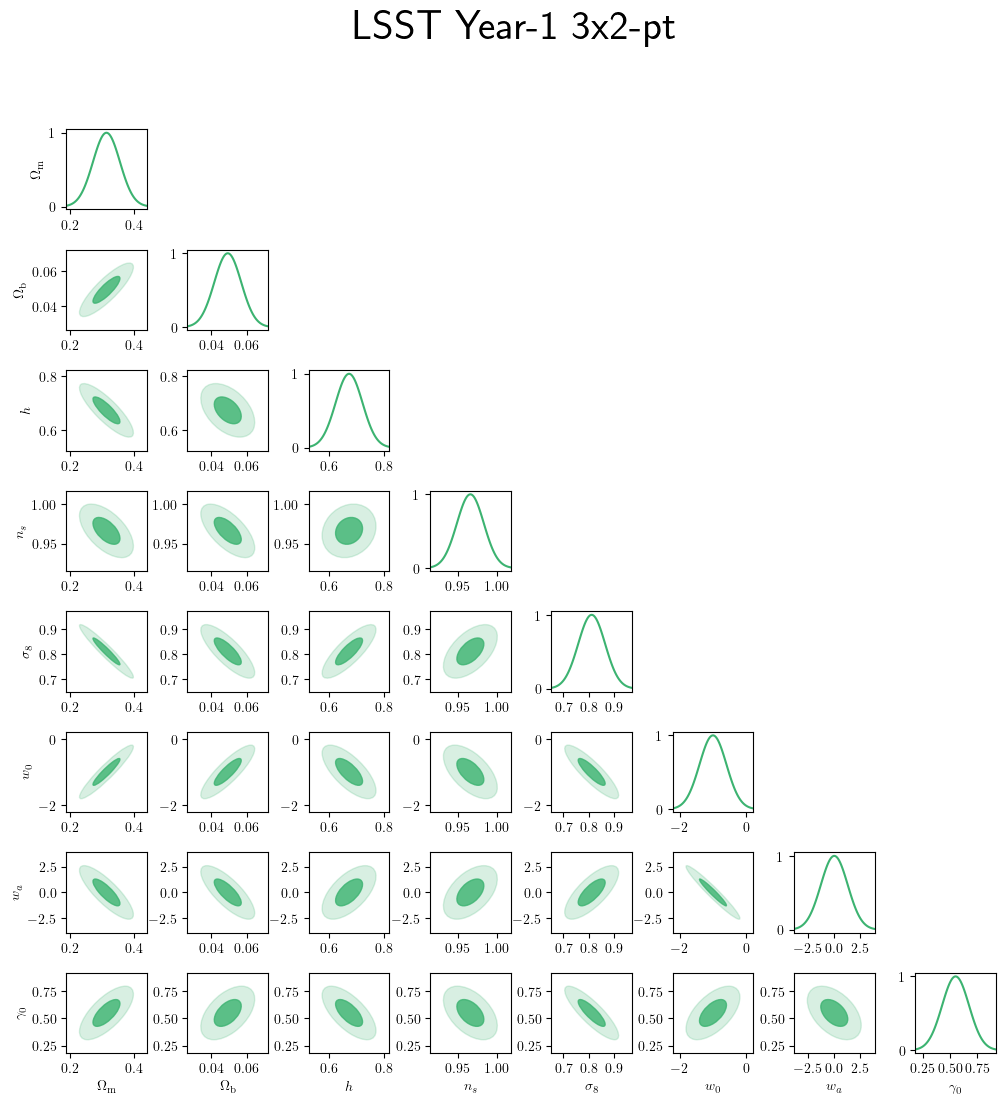

In [48]:
extract_params=8
param_names = (r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', '$h$', r'$n_s$', r'$\sigma_8$',
               r'$w_0$', r'$w_a$',
               r'$\gamma_0$')
               #r'$\gamma_0$',r'$\gamma_1$')
               #r'$b_{l,1}$', r'$b_{l,2}$', r'$b_{l,3}$', r'$b_{l,4}$', r'$b_{l,5}$')

fisher_inv = jax.scipy.linalg.inv(fisher)

fig= plt.figure(figsize=(extract_params*1.5, extract_params*1.5))
plt.rcParams.update({
    "font.size": 10})
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(extract_params):
    for j in range(extract_params):
        if j<i:
            plt.subplot(extract_params,extract_params,i*extract_params+j+1)
            plot_contours(fisher_inv, fid_params, np.array([j,i]),fill=True,antialiased=True,color='mediumseagreen')
        if j==i:
            plt.subplot(extract_params, extract_params, i*extract_params+j+1)
            plot_Gaussian(fisher_inv, fid_params, i, color='mediumseagreen')
        if i == extract_params - 1:
            plt.xlabel(param_names[j])
        if j == 0:
            plt.ylabel(param_names[i])
fig.suptitle(r'LSST Year-1 3x2-pt', fontsize=30)

saveFisher(fid_params, fisher, fname='gamma_sigma8-Omegam_LSSTY1_fisher.csv')